This notebook aims to investigate the distribution of lightning and calculate the lightning NO2 (LNO2) emission based on relationship between lightning frequency and LNO2 production efficiency.

In [1]:
import pandas as pd
import proplot as pplt
import xarray as xr
import numpy as np
from matplotlib.colors import LogNorm

from pyresample import kd_tree
from pyresample.geometry import GridDefinition, SwathDefinition
from pyresample.bucket import BucketResampler
from scipy import stats
from functools import lru_cache
from pyproj import Geod
from matplotlib.ticker import PercentFormatter

## Read Data

### Summer lightning

In [2]:
lightning_summer = xr.open_dataset('../data/gld360/gld_stroke_summer.nc').groupby("time.season").sum().sel(season='JJA')

### Mean NO2 VCDs

In [3]:
no2_mean = xr.open_dataset('../data/s5p_no2_PAL_v231_gridding_2x2_3year_mean.nc')['no2_vcd_trop_gridded']
# subset to arctic and resample to 0.1 deg
no2_mean = no2_mean.where(no2_mean.coords['lat']>=60, drop=True).coarsen(lon=5, lat=5).mean()

### Gridded LNO2

In [4]:
lno2_grid = xr.open_dataset('../data/S5P_LNO2_grid.nc')['lno2'].mean(dim='swath', skipna=True)

### LNO2 PE

In [5]:
def filter_case(df):
    df_high_lightning = df[df['nlightning']>100][df[df['nlightning']>100].groupby('case')['lno2'].transform('count') > 1]
    df_lno2 = df_high_lightning[(df_high_lightning['pe_lno2']>0)&(df_high_lightning['pe_lno2geo']>0)&(df_high_lightning['pe_lno2vis'])>0]

    return df_lno2

df = pd.read_csv('../data/S5P_LNO2_production.csv')
df = filter_case(df)
df['lfr'] = df['nlightning']/df['area']

## Lightning and NO2 map

In [6]:
df_lightning = pd.read_csv('../data/gld360/gld-stroke-count-m0p1.csv')
df_lightning.set_index(['time'], inplace=True)
df_lightning.index = pd.to_datetime(df_lightning.index)

In [7]:
def plot_lightning_tseries(df, ax):
    """Plot the time series of 10-min counts"""
    count_60_10min = df[(df['latitude'] >= 60)]['eventCount'].resample('10Min').sum()
    count_70_10min = df[(df['latitude'] >= 70)]['eventCount'].resample('10Min').sum()
    count_80_10min = df[(df['latitude'] >= 80)]['eventCount'].resample('10Min').sum()

    l1 = ax.plot(count_60_10min.index, count_60_10min, c='blue7', label='> 60$^{\circ}$N')
    l2 = ax.plot(count_70_10min.index, count_70_10min, c='lime7', label='> 70$^{\circ}$N')
    l3 = ax.plot(count_80_10min.index, count_80_10min, c='red7', label='> 80$^{\circ}$N')

    ax.legend([l1, l2, l3], loc='ul')

    ax.format(xlabel='', #'Date',
              ylabel='Strokes per 10 min', grid=False,
              xlocator=('month', range(1, 12, 4)), xrotation=0,
              xminorlocator='month',
              yscale='log', ymin=1, yformatter='log')


def plot_lightning_geo(lightning_summer, ax):
    """Plot the geo distribution of summed count"""
    lats, lons = np.meshgrid(lightning_summer['latitude'], lightning_summer['longitude'])

    m = ax.pcolormesh(lons, lats, lightning_summer['eventCount'].where(lightning_summer['eventCount']>0),
                      cmap='Spectral_r', norm=LogNorm(), discrete=False)

    ax.colorbar([m], loc='l', label='')
    ax.format(title='Total Arctic strokes')


def plot_mean_no2(no2_mean, ax):
    lons, lats = np.meshgrid(no2_mean['lon'], no2_mean['lat'])

    m = ax.pcolormesh(lons, lats, no2_mean, cmap='Spectral_r', vmin=0, vmax=30, discrete=False)

    ax.colorbar([m], loc='r', label='$\mu$mol m$^{-2}$')
    ax.format(title='Mean NO$_2$ tropospheric column')

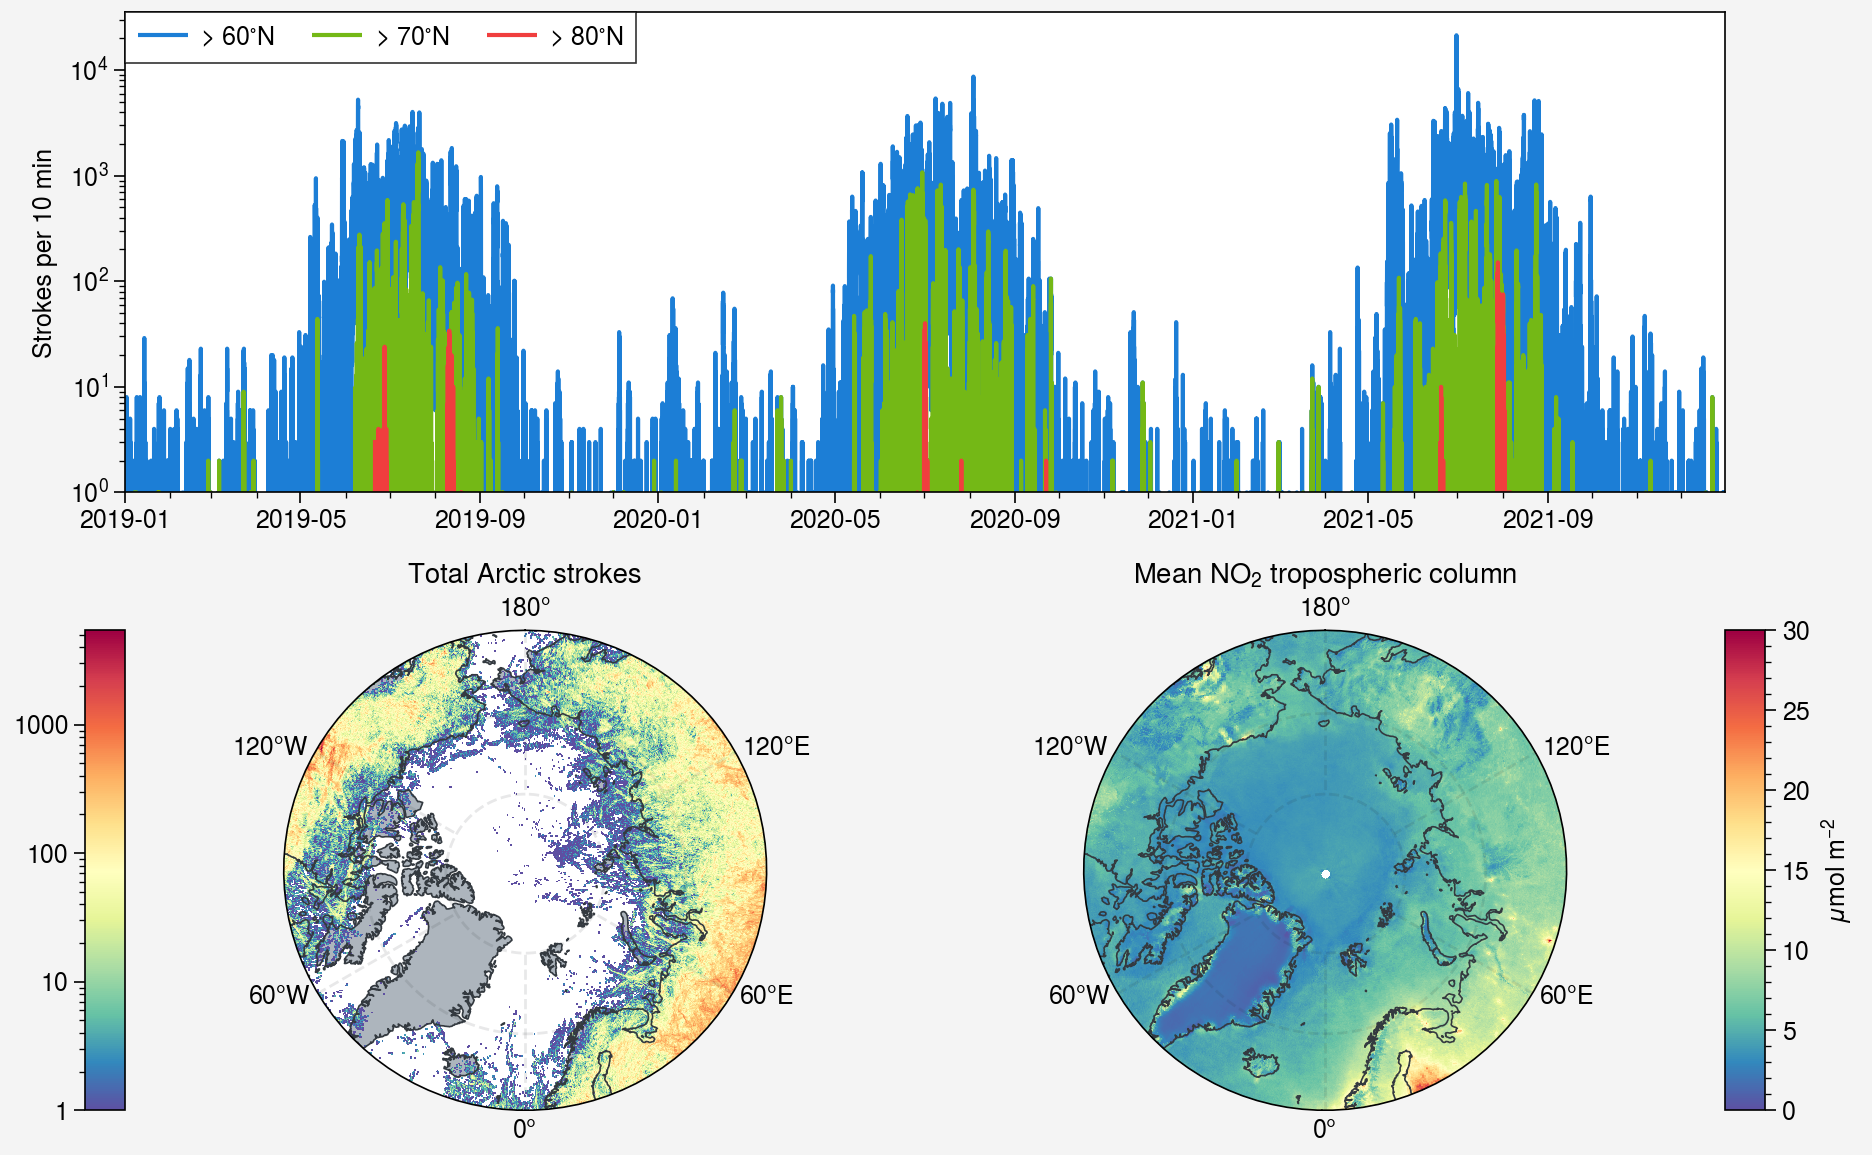

In [8]:
fig, axs = pplt.subplots([[1, 1],[2, 3]], axwidth=8, aspect=(10,3), share=0,
                         proj=[None, 'npstere', 'npstere'])

axs[1:].format(reso='med',
        latlines=10, gridcolor='gray9', gridlinewidth=1, gridlinestyle='--',
        # latinline=True, gridlabelcolor='w',
        lonlabels='lrbt', boundinglat=60,
        landcolor='gray5', land=True, coast=True, coastcolor='gray8',
        )

plot_lightning_tseries(df_lightning, axs[0])
plot_lightning_geo(lightning_summer, axs[1])
plot_mean_no2(no2_mean, axs[2])

# fig.savefig('../figures/distributions.png')

## PE map and relationships

/home/xin/miniconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: ProplotWarning: Ignoring unused keyword arg(s): {'cmap': ContinuousColormap({
 'name': 'Greys',
 'cyclic': False,
 'red': [1.00, ..., 0.00],
 'green': [1.00, ..., 0.00],
 'blue': [1.00, ..., 0.00],
 'alpha': [1.00, ..., 1.00],
})}
  scatter = ax.scatter(
/home/xin/miniconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: ProplotWarning: Ignoring unused keyword arg(s): {'cmap': ContinuousColormap({
 'name': 'Greys',
 'cyclic': False,
 'red': [1.00, ..., 0.00],
 'green': [1.00, ..., 0.00],
 'blue': [1.00, ..., 0.00],
 'alpha': [1.00, ..., 1.00],
})}
  scatter = ax.scatter(


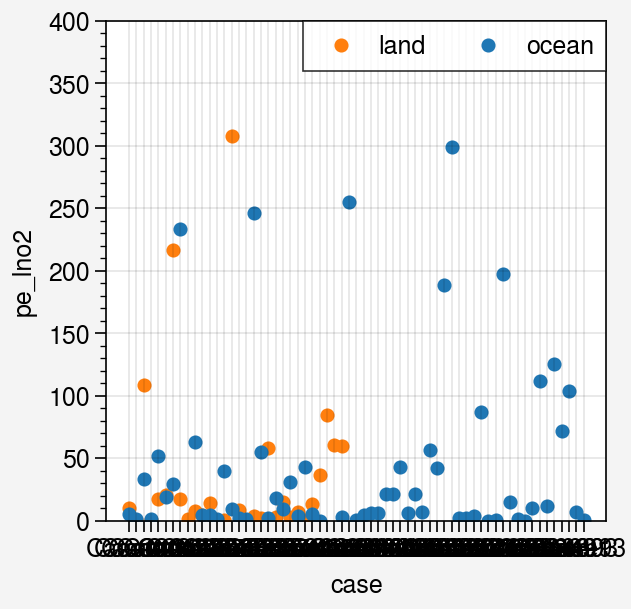

In [9]:
fig, axs = pplt.subplots()
colors = {'ocean':'tab:blue', 'land':'tab:orange'}
grouped = df.groupby('region')
for key, group in grouped:
    group.plot(ax=axs, kind='scatter', x='case', y='pe_lno2', label=key, color=colors[key])

axs.format(ylim=(0, 400))

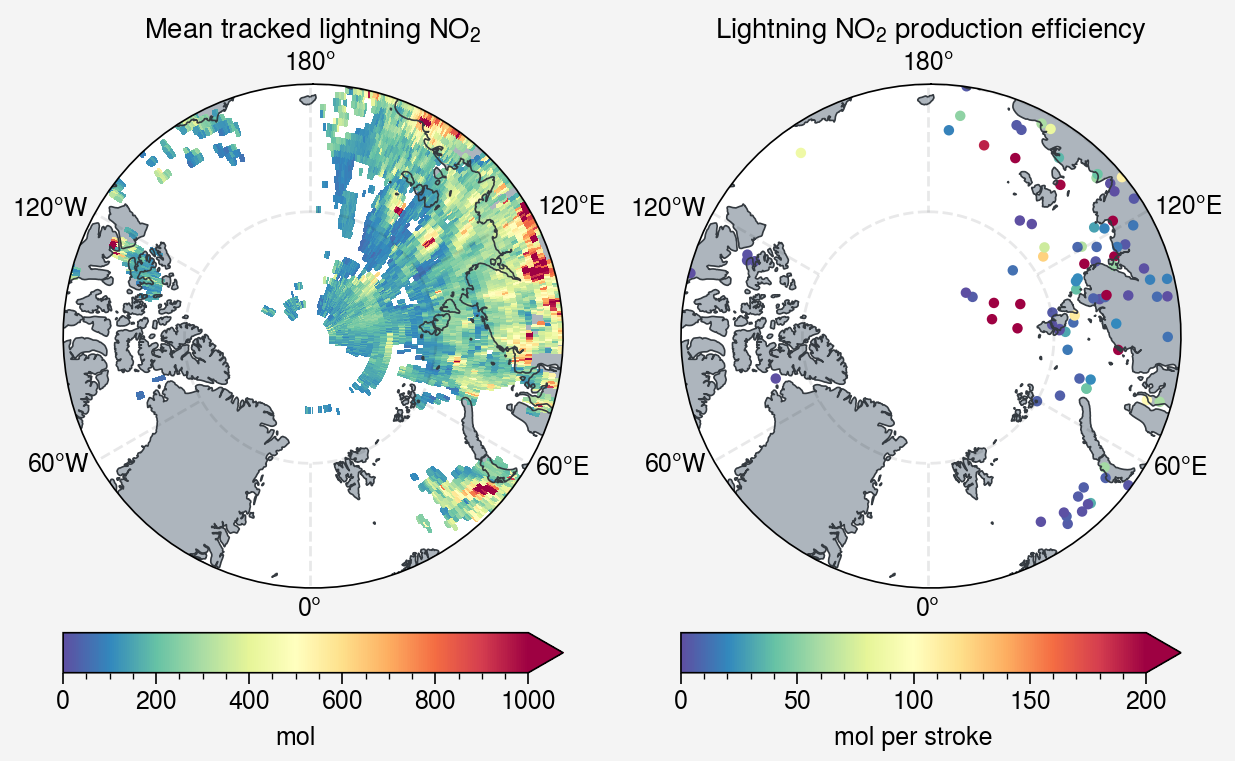

In [10]:
fig, axs = pplt.subplots(proj='npstere', ncols=2)

axs.format(reso='med',
        latlines=10, gridcolor='gray9', gridlinewidth=1, gridlinestyle='--',
        # latinline=True, gridlabelcolor='w',
        lonlabels='lrbt', boundinglat=70,
        landcolor='gray5', land=True, coast=True, coastcolor='gray8',
        )


def plot_lno2_grid(lno2_grid, ax):
    lats, lons = np.meshgrid(lno2_grid['latitude'], lno2_grid['longitude'])

    m = ax.pcolormesh(lons, lats, lno2_grid, cmap='Spectral_r', vmin=0, vmax=1e3, discrete=False, extend='max')
    # m = ax.scatter(lons.ravel(), lats.ravel(), c=lno2_grid.values.ravel(), s=5, cmap='Spectral_r', vmin=0, vmax=400, discrete=False, extend='max')

    ax.colorbar([m], loc='b', label='mol')
    ax.format(title='Mean tracked lightning NO$_2$')

def plot_pe(df, ax):
    s = ax.scatter(df['longitude'], df['latitude'], c=df['pe_lno2'], vmin=0, vmax=200, s=10, extend='max', cmap='Spectral_r')
    ax.colorbar([s], loc='b', label='mol per stroke')
    ax.format(title='Lightning NO$_2$ production efficiency')

plot_lno2_grid(lno2_grid, axs[0])
plot_pe(df, axs[1])

## Relationships

### LNO2 ~ Lightning

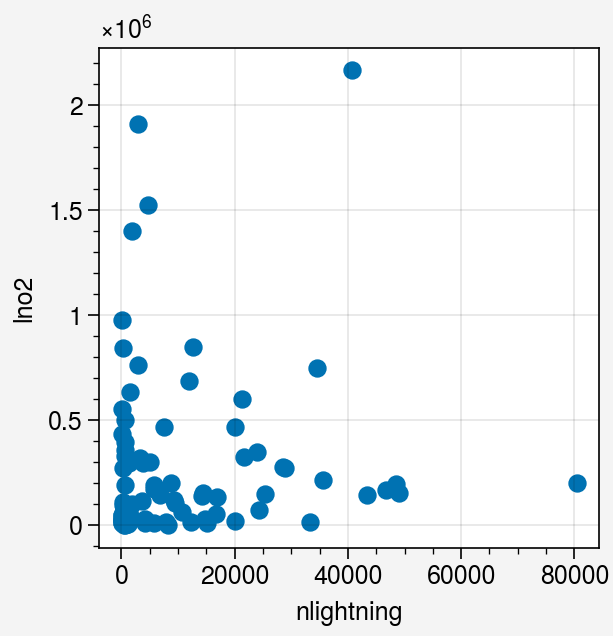

In [11]:
fig, axs = pplt.subplots()

axs.scatter(df['nlightning'], df['lno2'])

When there's more lightning, the lighnting NO2 Production doesn't increase. This means the lightning NO2 production efficiency may be different.

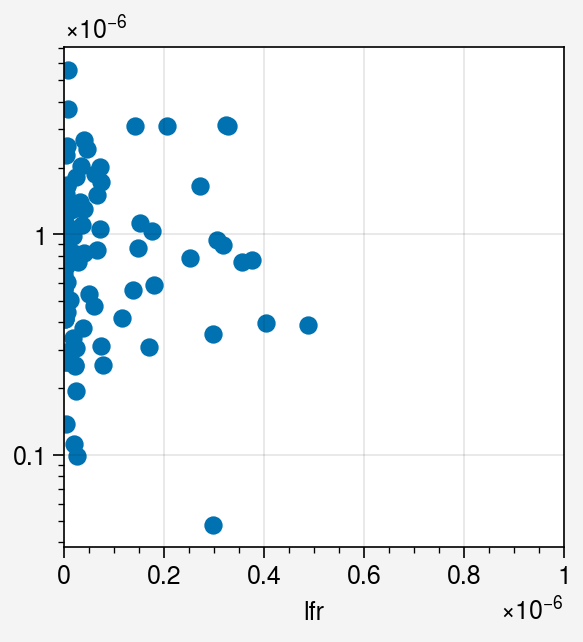

In [12]:
fig, axs = pplt.subplots()

axs.scatter(df['lfr'], df['lno2']/df['area'])
# axs.scatter(df['nlightning'], df['lno2'])

# axs.format(xlim=(100, 4000), ylim=(1e-9, 1e-7))
# axs.format(ylim=(1e-6, 1e-3), yscale='log')
axs.format(xlim=(0, 1e-6), yscale='log')

It seems the LNO2 production isn't affected by lightning flash rate.

### PE ~ Lightning Frequency (\#/(h*m2))

R² = 0.8136811814270708


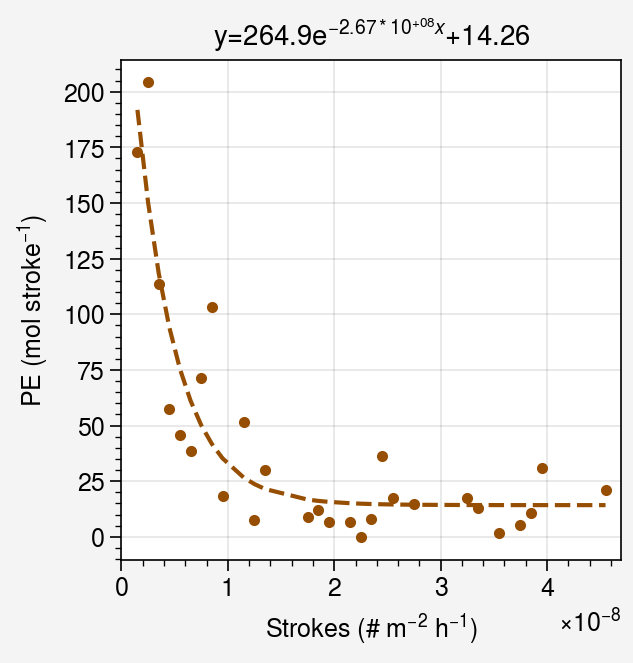

In [13]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

# perform the fit
from scipy.optimize import curve_fit

lfr_bins = np.arange(1e-9, 5e-8, 1e-9)
lfr_mid = pd.Series(lfr_bins).rolling(2).mean()[1:].values
pe_bin = df.groupby(pd.cut(df['lfr'], bins=lfr_bins))['pe_lno2'].mean()
pe_std = df.groupby(pd.cut(df['lfr'], bins=lfr_bins))['pe_lno2'].std()

valid_mask = np.logical_not(np.isnan(pe_bin))
xs = lfr_mid[valid_mask]
ys = pe_bin[valid_mask]

p0 = (2000, .1, 50) # start with values near those we expect
params, cv = curve_fit(monoExp, xs, ys, p0)
m, t, b = params
sampleRate = 20_000 # Hz
tauSec = (1 / t) / sampleRate

# determine quality of the fit
squaredDiffs = np.square(ys - monoExp(xs, m, t, b))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

def plot_pe_lfr(x, y, m, t, b, ax):
    ax.plot(xs, ys, '.', c='warm brown')
    # l = ax.plot(xs, monoExp(xs, m, t, b), '--', label="pe = {} * e^{} lfr + {}".format(round(m, 3), -round(t, 2), round(b, 2)))
    l = ax.plot(xs, monoExp(xs, m, t, b), '--', c='warm brown')#, label="y = 264.9e$^{-2.67*10^{8}x}$ + 14.3")

    # ax.legend(l, loc='ur')
    base, power = f'{-t:.2e}'.split('e')
    ax.format(xlabel='Strokes (# m$^{-2}$ h$^{-1}$)', ylabel='PE (mol stroke$^{-1}$)',
              xlim=(0, 4.7e-8),
              title=f'y={m.round(2)}e$^{{{base}*10^{{{power}}}x}}$+{b.round(2)}')

# plot the results
fig, axs = pplt.subplots()
plot_pe_lfr(xs, ys, m, t, b, axs)

### PE ~ Cloud pressure

In [14]:
# df.plot.scatter(x='apparent_scene_pressure', y='pe_lno2', ylim=(0, 100))
# df.plot.scatter(x='apparent_scene_pressure', y='lfr')#, ylim=(0, 100))

## LNO2 production

### Clustered hourly GLD360

In [15]:
lon_bnds = np.arange(-180, 180.5, 0.5)
lat_bnds = np.arange(60, 90.5, 0.5)
lon_bounds2d, lat_bounds2d = np.meshgrid(lon_bnds, lat_bnds)

@lru_cache(maxsize=2**10)
def calc_area():
    """Calculate area of each pixel"""
    geod = Geod(ellps="WGS84")

    len_x = lon_bounds2d.shape[0]-1
    len_y = lon_bounds2d.shape[1]-1
    area = np.full((len_x, len_y), 0)

    for x in range(len_x):
        for y in range(len_y):
            # get the corner coordinates
            lons = lon_bounds2d[x:x+2, y:y+2].ravel()
            lats = lat_bounds2d[x:x+2, y:y+2].ravel()

            # clockwise direction
            lons[-2], lons[-1] = lons[-1], lons[-2]
            lats[-2], lats[-1] = lats[-1], lats[-2]

            # get the area
            poly_area, poly_perimeter = geod.polygon_area_perimeter(lons, lats)
            area[x, y] = poly_area

    return xr.DataArray(area, dims=['latitude', 'longitude'],
                        coords={'longitude': lon_bnds[:-1], 'latitude': lat_bnds[:-1]})

area_05deg = calc_area()

In [16]:
def hourly_lfr(df):
    # calculate the hourly lightning in 0.5*0.5 degree (= 5 indexes)
    # https://stackoverflow.com/a/39277772/7347925
    step = 5
    to_bin = lambda x: np.floor(x / step) * step

    df['lon_bin'] = to_bin(df.longitude)
    df['lat_bin'] = to_bin(df.latitude)
    df.groupby(["lon_bin", "lat_bin"])['eventCount'].sum()

    df['lfr'] = df['eventCount']/area_05deg.sel(longitude=xr.DataArray(df['lon_bin']), latitude=xr.DataArray(df['lat_bin']))

    return df

In [17]:
# calculate the hourly lightning count
df_lightning_hourly = df_lightning.groupby([pd.Grouper(freq='1H'), 'longitude', 'latitude'])['eventCount'].sum().reset_index()
# calculate the hourly lightning frequency
df_lightning_hourly = df_lightning_hourly.groupby('time').apply(hourly_lfr)
# calculate the hourly lightning NO2 emission
df_lightning_hourly['lno2'] = df_lightning_hourly['lfr'].apply(lambda x: m*np.exp(-t*x) + b)*df_lightning_hourly['eventCount']

In [18]:
lno2_emission = df_lightning_hourly.groupby([df_lightning_hourly.time.dt.year, 'longitude', 'latitude'])['lno2'].sum().to_xarray()
lno2_emission = lno2_emission.where(lno2_emission>0)

print('LNO2: ', (lno2_emission.mean('time').sum() * 14 / 1e9).round(2).values, 'Gg per year')
print('LNO2 (>70N): ', (lno2_emission.where(lno2_emission['latitude']>70).mean('time').sum() * 14 / 1e9).round(2).values, 'Gg per year')
print('LNO2 (>80N): ', (lno2_emission.where(lno2_emission['latitude']>80).mean('time').sum() * 14 / 1e9).round(3).values, 'Gg per year')

LNO2:  7.04 Gg per year
LNO2 (>70N):  0.58 Gg per year
LNO2 (>80N):  0.014 Gg per year


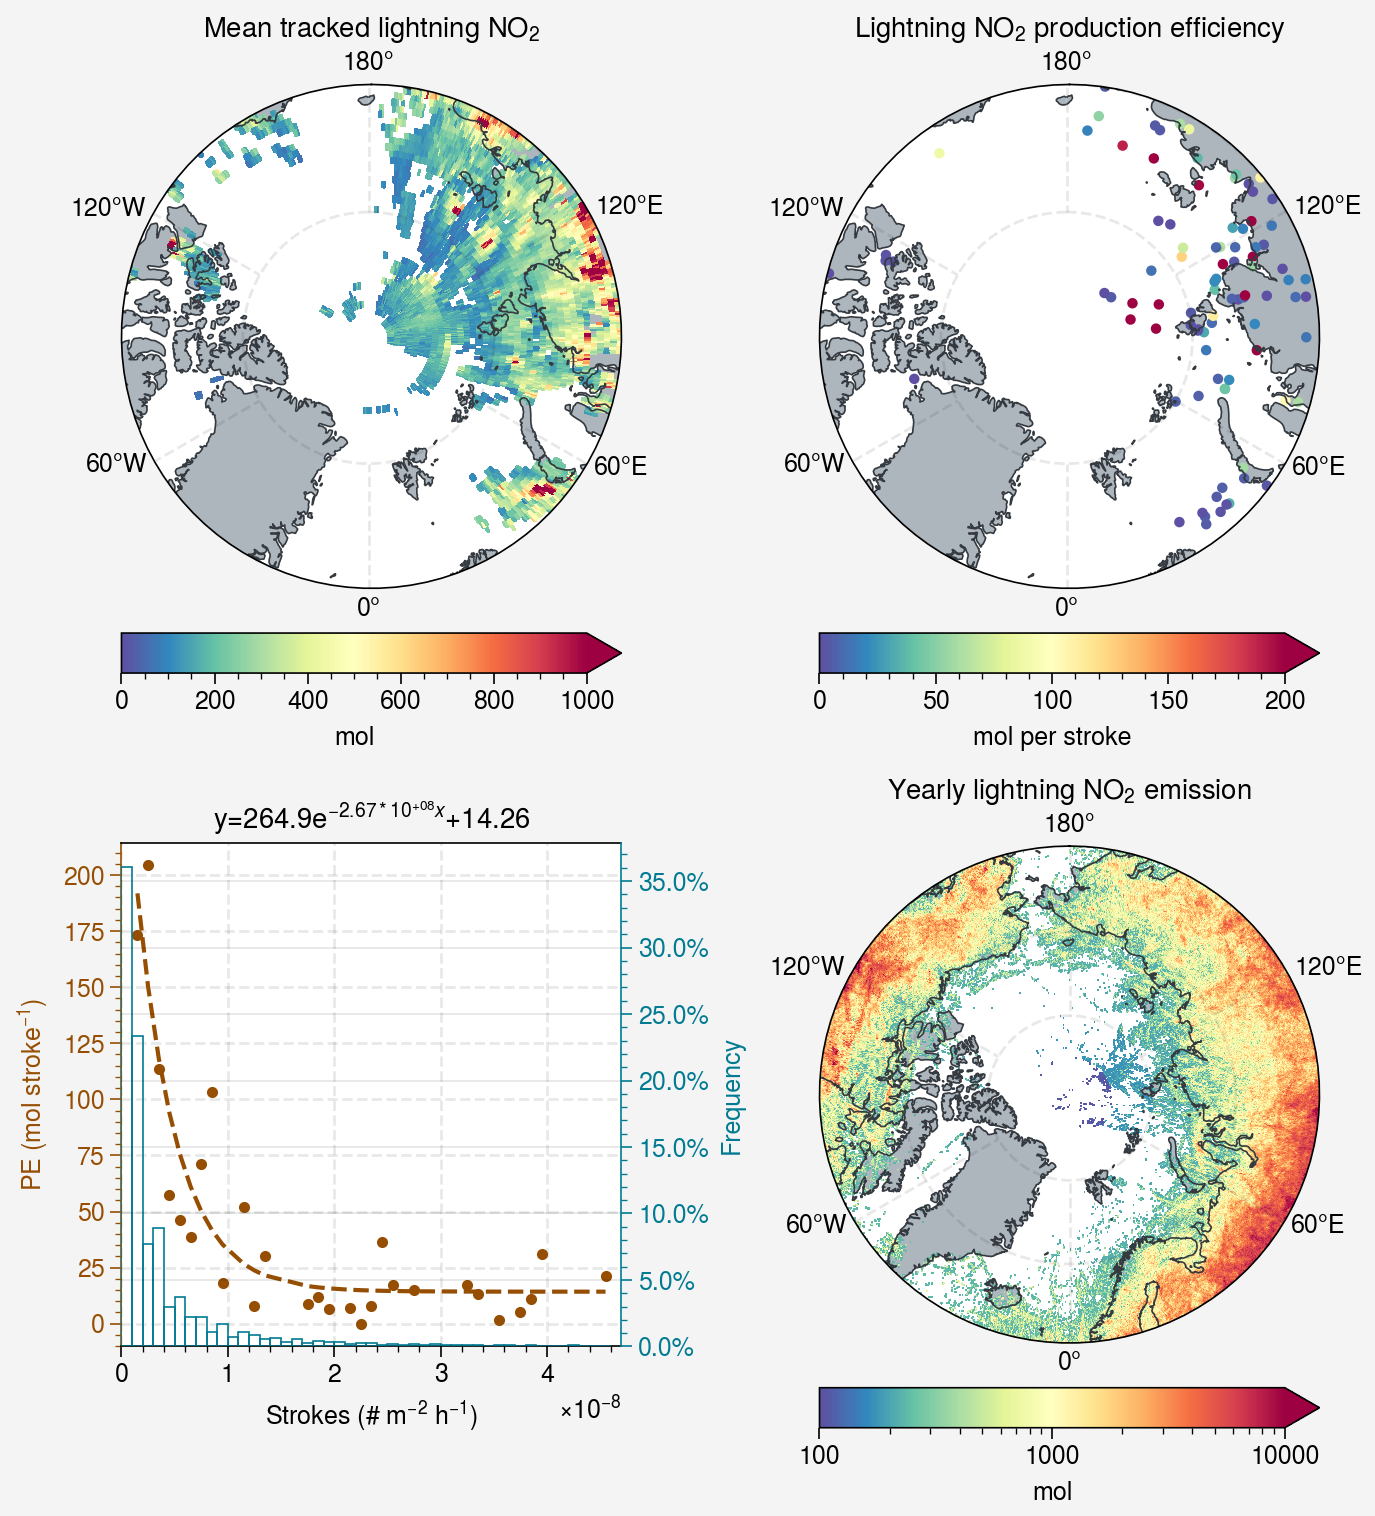

In [19]:
def plot_lno2(data, ax):
    lats, lons = np.meshgrid(data['latitude'], data['longitude'])
    m = ax.pcolormesh(lons, lats, data.mean(dim=['time']), vmin=100, vmax=1e4, cmap='Spectral_r', norm=LogNorm(), discrete=False)
    ax.colorbar([m], loc='b', label='mol', extend='max')
    ax.format(title=f'Yearly lightning NO$_2$ emission')

fig, axs = pplt.subplots(nrows=2, ncols=2, proj=['npstere', 'npstere', None, 'npstere'], share=0)

axs.format(reso='med',
        latlines=10, gridcolor='gray9', gridlinewidth=1, gridlinestyle='--',
        # latinline=True, gridlabelcolor='w',
        lonlabels='lrbt',
        landcolor='gray5', land=True, coast=True, coastcolor='gray8',
        )

axs[:2].format(boundinglat=70)
axs[3].format(boundinglat=60)

plot_lno2_grid(lno2_grid, axs[0])
plot_pe(df, axs[1])
plot_pe_lfr(xs, ys, m, t, b, axs[2])

ax = axs[2].twinx()
df_lightning_hourly['lfr'].plot.hist(bins=np.arange(0, 4.7e-8, 1e-9),
                                     weights=np.ones(len(df_lightning_hourly)) / len(df_lightning_hourly),
                                     ec='ocean', fc='None', ax=ax)
ax.yaxis.set_major_formatter(PercentFormatter(1))
axs[2].format(ycolor='warm brown')
ax.format(ycolor='ocean')

plot_lno2(lno2_emission, axs[3])